# Using convnets with small datasets

Perform an image classification task (Dogs vs Cats) using a small dataset of images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import models, layers, optimizers, losses, metrics
from tensorflow.keras.datasets import mnist
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical

## Create dataset

After having downloaded the dataset from https://www.kaggle.com/c/dogs-vs-cats/data, let's create train, validation and test datasets for each category. The intention is to have a train dataset of 1000 images per each category and validation and test datasets made of 500 images per category.

In [18]:
%run ./datasets/create_cats_dogs_datasets.py

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


## Building the network

The structure will be another stack of `Conv2D` and `MaxPooling2D` layers. Being the problem more difficult than a classic MNIST toy-problem, the network will be larger, accordingly.

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

#### Compile the model

In [4]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Data preprocessing

The data is still in JPEG format, so we need to process it in order in an appropriate format that can be used to feed the model. We need to:
- read the files;
- decode the JPEG content to a RGB grod of pixels;
- transform the grids into floating-point tensors;
- rescape the pixel values into values included in the interval `[0, 1]`

Keras has libraries that allows to automatize those operations, returning generators that do the wanted tasks.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "./datasets/cats_and_dogs_small/train"
VALIDATION_DIR = "./datasets/cats_and_dogs_small/validation"

# rescale all images by 1/255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,              # target dir
    target_size=(150, 150), # resizes all images to 150x150
    batch_size=20,
    class_mode='binary'     # Binary labels needed with binary_crossentropy loss
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Sanity check for the shape of data and labels batches:

In [8]:
for data_batch, labels_batch in train_generator:
    print(f"Data batch shape: {data_batch.shape}")
    print(f"Labels batch shape: {labels_batch.shape}")
    break # Necessary because the generator yields batches indefinitely

Data batch shape: (20, 150, 150, 3)
Labels batch shape: (20,)


## Training

Fit the model using the generators. The new version of Keras still supports `fit_generator`, but it's about to be deprecated. Better use `fit`, which now has the support for generators. 
The first argument is the Python generator that will yield training batches of inputs and targets indefinitely (`train_generator`). Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator, i.e. after having run for steps_per_epoch gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using fit_generator, one may pass a `validation_data` argument, much like with the fit method. Importantly, this argument is allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly, and thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/30
100/100 [==============================] - 33s 327ms/step - loss: 0.5735 - accuracy: 0.7120 - val_loss: 0.5910 - val_accuracy: 0.6640
Epoch 2/30
100/100 [==============================] - 35s 351ms/step - loss: 0.5173 - accuracy: 0.7440 - val_loss: 0.5439 - val_accuracy: 0.7300
Epoch 3/30
100/100 [==============================] - 35s 352ms/step - loss: 0.4639 - accuracy: 0.7810 - val_loss: 0.5719 - val_accuracy: 0.7060
Epoch 4/30
100/100 [==============================] - 35s 350ms/step - loss: 0.4139 - accuracy: 0.8115 - val_loss: 0.5684 - val_accuracy: 0.7250
Epoch 5/30
100/100 [==============================] - 36s 365ms/step - loss: 0.3616 - accuracy: 0.8410 - val_loss: 0.6718 - val_accuracy: 0.7150
Epoch 6/30
100/100 [==============================] - 35s 354ms/step - loss: 0.3198 - accuracy: 0.8625 - val_loss: 0.6575 - val_accuracy: 0.7570
Epoch 7/30
100/100 [=================

#### Save the model

In [11]:
model.save('models/cats_and_dogs_small.h5')

#### Plot loss and accuracy

The graphs below shows the characteristics of overfitting. The training accuracy increases linearly over time, until it reaches 100%, whereas the validation accuracy stalls around 72%. Interesting also to see how noisy are noth the validation loss and accuracy curves.

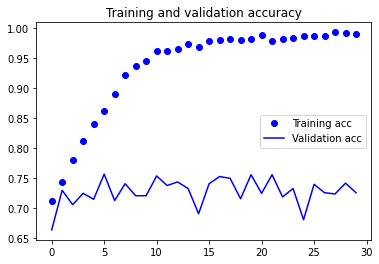

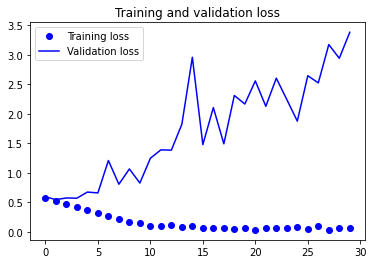

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


## Tackling overfitting

Having relatively few training examples (2000) could be a possible main cause for overfitting. Let's tackle it with a new technique than the ones previously analyzed (regularizations and dropout).

### Using data augmentation

Data augmentation takes the approach of generating new data from the existing samples, by _augmenting_ the samples via a number of random transformations that yield believable-looking images. In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the `ImageDataGenerator` instance. More info about possible transformations could be found [in the related Keras docs](https://keras.io/preprocessing/image/).

#### Create generators configured for data augmentation

So, let's start by redefining the `train_generator` by adding some data augmentation transformations. Note that validation data **will not be augmented**. In particular:

- `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures;
- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally;
- `shear_range` is for randomly applying shearing transformations;
- `zoom_range` is for randomly zooming inside pictures;
- `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [64]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Edit network architecture

With data augmentation, we can be sure that the model will not get the same input twice. But, it's also true that we are not properly generating new data but it's just a remix of existing information. It means that certain patterns could be learned multiple times, which could be a factor acting against us trying to get rid of overfitting. To address this problem we will try to add a `Dropout` layer, right before the classifier part.

In [65]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 15, 15, 128)      

In [66]:
model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### Train the new model

In [67]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=150,
    validation_data=validation_generator,
    validation_steps=50,
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/150
100/100 [==============================] - 36s 359ms/step - loss: 0.6931 - accuracy: 0.5155 - val_loss: 0.6824 - val_accuracy: 0.5920
Epoch 2/150
100/100 [==============================] - 37s 372ms/step - loss: 0.6826 - accuracy: 0.5480 - val_loss: 0.7154 - val_accuracy: 0.5040
Epoch 3/150
100/100 [==============================] - 39s 386ms/step - loss: 0.6751 - accuracy: 0.5665 - val_loss: 0.6550 - val_accuracy: 0.5980
Epoch 4/150
100/100 [==============================] - 38s 379ms/step - loss: 0.6627 - accuracy: 0.5885 - val_loss: 0.6462 - val_accuracy: 0.6110
Epoch 5/150
100/100 [==============================] - 38s 382ms/step - loss: 0.6386 - accuracy: 0.6305 - val_loss: 0.6212 - val_accuracy: 0.6490
Epoch 6/150
100/100 [==============================] - 38s 383ms/step - loss: 0.6329 - accuracy: 0.6400 - val_loss: 0.6578 - val_accuracy: 0.5880
Epoch 7/150
100/100 [==========

100/100 [==============================] - 38s 376ms/step - loss: 0.4606 - accuracy: 0.7870 - val_loss: 0.4665 - val_accuracy: 0.7860
Epoch 56/150
100/100 [==============================] - 38s 376ms/step - loss: 0.4503 - accuracy: 0.7895 - val_loss: 0.5632 - val_accuracy: 0.7290
Epoch 57/150
100/100 [==============================] - 37s 375ms/step - loss: 0.4532 - accuracy: 0.7800 - val_loss: 0.5956 - val_accuracy: 0.7230
Epoch 58/150
100/100 [==============================] - 37s 374ms/step - loss: 0.4577 - accuracy: 0.7845 - val_loss: 0.5802 - val_accuracy: 0.7130
Epoch 59/150
100/100 [==============================] - 37s 373ms/step - loss: 0.4481 - accuracy: 0.7795 - val_loss: 0.4534 - val_accuracy: 0.7880
Epoch 60/150
100/100 [==============================] - 37s 373ms/step - loss: 0.4352 - accuracy: 0.7965 - val_loss: 0.4802 - val_accuracy: 0.7840
Epoch 61/150
100/100 [==============================] - 37s 374ms/step - loss: 0.4532 - accuracy: 0.7945 - val_loss: 0.4231 - val_a

Epoch 111/150
100/100 [==============================] - 38s 380ms/step - loss: 0.3706 - accuracy: 0.8375 - val_loss: 0.4074 - val_accuracy: 0.8220
Epoch 112/150
100/100 [==============================] - 38s 384ms/step - loss: 0.3640 - accuracy: 0.8375 - val_loss: 0.4811 - val_accuracy: 0.7950
Epoch 113/150
100/100 [==============================] - 41s 406ms/step - loss: 0.3618 - accuracy: 0.8360 - val_loss: 0.4291 - val_accuracy: 0.8070
Epoch 114/150
100/100 [==============================] - 39s 387ms/step - loss: 0.3565 - accuracy: 0.8425 - val_loss: 0.4522 - val_accuracy: 0.8050
Epoch 115/150
100/100 [==============================] - 39s 385ms/step - loss: 0.3616 - accuracy: 0.8395 - val_loss: 0.4339 - val_accuracy: 0.8280
Epoch 116/150
100/100 [==============================] - 39s 388ms/step - loss: 0.3515 - accuracy: 0.8430 - val_loss: 0.4497 - val_accuracy: 0.8030
Epoch 117/150
100/100 [==============================] - 39s 391ms/step - loss: 0.3563 - accuracy: 0.8470 - val_

#### Save the new model

In [68]:
model.save('models/cats_and_dogs_small_2.h5')

## Plot the results (again)

Thanks to data augmentation and dropout, we are no longer overfitting. Even though the validation loss has very high variance it follows the trend of the training loss. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with.

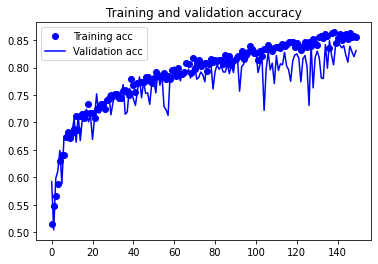

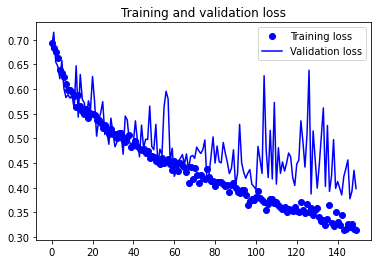

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()